In [ ]:
!pip install catboost

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRanker, Pool

# 1. Подготовка данных

In [5]:
to_drop = ['feature_3', 'feature_12', 'feature_53', 'feature_65', 'feature_71', 'feature_77',
           'feature_0', 'feature_73', 'feature_74', 'feature_75']

train_df = pd.read_csv("/content/drive/MyDrive/data/data/train_df.csv")
train_df = train_df.drop(to_drop, axis=1)
test_df = pd.read_csv("/content/drive/MyDrive/data/data/test_df.csv")
test_df = test_df.drop(to_drop, axis=1)

In [6]:
X_train = train_df.drop(["search_id", "target"], axis=1).values
y_train = train_df["target"].to_numpy(dtype=np.float32)
queries_train = train_df["search_id"].values

X_test = test_df.drop(["search_id", "target"], axis=1).values
y_test = test_df["target"].to_numpy(dtype=np.float32)
queries_test = test_df["search_id"].values

In [7]:
num_queries = np.unique(queries_train).shape[0]
num_queries

1000

In [8]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test
)

# 2. Выбор параметров модели

Поскольку целевая переменная (target) является бинарной (например, клик по объекту), то целесообразно в качестве функции потерь для обучения ранжированию использовать **CrossEntropy** по каждой группе, т.к. данная функция потерь является обоснованной относительно MLE. Поскольку данные разбиты по группам (запросам), то подсчет CrossEntropy также стоит производить по группам (в catboost уже имеется реализация – **QueryCrossEntropy** [reference](https://catboost.ai/en/docs/references/querycrossentropy)).

Обучение будет производится на GPU (Google Colab T4).

Для поиска оптимальных параметров будем использовать значение функции потерь на тестовой выборке.



In [ ]:
parameters = {
    'loss_function': "QueryCrossEntropy",
    'task_type': "GPU",
    'verbose': False
    }

params_to_gridsearch = {
    'depth': [2, 4, 6],
    'iterations': [100, 250, 500],
    'learning_rate': [0.05, 0.2, 0.3],
    }


model = CatBoostRanker(**parameters)
grid_search_result = model.grid_search(params_to_gridsearch, X=train_pool, cv=5, verbose=False)

In [10]:
best_params = grid_search_result["params"]
best_params

{'depth': 2, 'learning_rate': 0.2, 'iterations': 250}

# 3. Обучение базовой модели

In [ ]:
from sklearn.model_selection import StratifiedKFold


final_parameters = dict(parameters)
final_parameters.update(best_params)
final_parameters['custom_metric'] = 'NDCG'

scores_list = []

for j in range(10):
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for i, (train_index, val_index) in enumerate(kf.split(X_train, queries_train)):

        train_pool = Pool(
            data=X_train[train_index],
            label=y_train[train_index],
            group_id=queries_train[train_index]
        )

        eval_pool = Pool(
            data=X_train[val_index],
            label=y_train[val_index],
            group_id=queries_train[val_index]
        )

        model = CatBoostRanker(**final_parameters)
        model.fit(train_pool, eval_set=eval_pool, verbose=False, plot=False)

        scores_list.append(model.score(test_pool))



Среднее значение NDCG: 0.9152735015066378


Text(0.5, 0, 'NDCG')

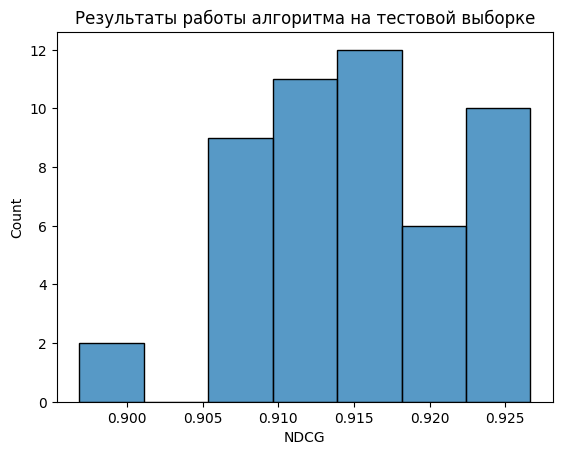

In [16]:
print(f"Среднее значение NDCG: {np.mean(scores_list)}")
sns.histplot(scores_list)
plt.title("Результаты работы алгоритма на тестовой выборке")
plt.xlabel("NDCG")

## Получаем $\text{NDCG}\approx$ 0.9153